In [0]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

**_Use the button above to toggle display of raw code in this notebook_**

- - - 

### SETTING UP FOR GOOGLE COLAB: BACK TO THE TOP

This notebook was run on the Google Colab platform to make use of the GPU resources available there.

In [0]:
# Mounting Google Drive directory and files
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Changing working directory to match setup in Google Drive
cd '/content/drive/My Drive/ProjectCapstone'

/content/drive/My Drive/ProjectCapstone


In [0]:
# Confirming new working directory
pwd

'/content/drive/My Drive/ProjectCapstone'

In [0]:
# Checking GPU connection
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- - -

# EDA - Capstone Project (Koios Medical)

by Sabbir Mohammed<br><br>*Project Description: Deep Learning Project focused on object localization of potential tumors and legions on thyroid ultrasound images.*<br><br>*This notebook executes simple exploratory analyses of the data source to examine the images available for model training and test. Additionally, this notebook outlines the image augmentation process utilized to deal with scarcity.*

- - -

<p><a name="home"></a></p>
### SECTIONS:
1. <a href="#initial">   Initializing</a><br>
2. <a href="#files">     Exploring Research Data Files</a><br>
3. <a href="#loading">   Loading .csv(s)</a><br>
4. <a href="#images">    Exploring Images</a><br>
5. <a href="#dataframes">Creating Data Sets</a><br>
6. <a href="#augment">   Image Augmentation</a><br>
7. <a href="#tvt">       Creating Training, Validation and Test Splits</a><br>
8. <a href="#print">     Printing Final Dataframes to .csv(s) </a><br>

- - -

<p><a name="initial"></a></p>
**1. INITIALIZING:**
<br><a href="#home">BACK TO THE TOP</a>

Loading necessary libraries

In [0]:
import PIL
import os

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import imgaug            as ia

from   imgaug            import augmenters as iaa
from   PIL               import Image

- - -

<p><a name="files"></a></p>
**2. EXPLORING RESEARCH DATA FILES:** 
<br><a href="#home">BACK TO THE TOP</a>

- Three folders ('maling', 'bening' and 'thyroid' with jpg and xml files for each ultrasound <br> 
- Three .csv files ('cases', 'coords' and 'images') <br>
    - 'cases' contains patient specific data for each ultrasound
    - 'coords' contains image IDs and bounding box coordinates
    - 'images' contains image filepaths and dictionary of points for image segmentation

- - -

<p><a name="loading"></a></p>
**3. LOADING .csv(s) FROM DATA FOLDER:**
<br><a href="#home">BACK TO THE TOP</a>

In [0]:
cases  = pd.read_csv('./cimalab/dataframe/cases.csv')
coors  = pd.read_csv('./cimalab/dataframe/coors.csv')
images = pd.read_csv('./cimalab/dataframe/images.csv')

Column Names for the three .csv(s):

In [0]:
a  = pd.Series(cases.columns)
b  = pd.Series(coors.columns)
c  = pd.Series(images.columns)

colnames = pd.DataFrame({'cases': a, 'coors': b, 'images': c}).fillna('')
colnames

,cases,coors,images
0,id,id,id
1,num,image_id,case_id
2,cancer,x,filename
3,age,y,mark
4,sex,w,
5,composition,h,
6,echogenicity,,
7,margins,,
8,calcification,,
9,tirads,,


In [0]:
pd.DataFrame({'': ['cases', 'coors', 'images'], 'Rows': [cases.shape[0], coors.shape[0], images.shape[0]]})\
.set_index('')

,Rows
,
cases,488
coors,779
images,618


- - -

<p><a name="images"></a></p>
**4. EXPLORING IMAGES:**
<br><a href="#home">BACK TO THE TOP</a>

 - Loading filenames from folders

In [0]:
folders      = ['bening', 'maling', 'thyroid']

bening_jpgs  = []
maling_jpgs  = []
thyroid_jpgs = []

bening_xmls  = []
maling_xmls  = []
thyroid_xmls = []

for folder in folders:
    for root, dirs, files in os.walk('./cimalab/'+folder):
        for filename in files:
            if 'jpg' in filename:
                eval(folder+'_jpgs').append(filename)

for folder in folders:
    for root, dirs, files in os.walk('./cimalab/'+folder):
        for filename in files:
            if 'xml' in filename:
                eval(folder+'_xmls').append(filename)

# Sanity Check:
print('{:35}{}{:6}'.format('Number of benign jpgs & xmls: ',   len(bening_jpgs),  len(bening_xmls)))
print('{:35}{}{:6}'.format('Number of malignant jpgs & xmls: ',len(maling_jpgs),  len(maling_xmls)))
print('{:35}{}{:6}'.format('Number of thyroid jpgs & xmls: ',  len(thyroid_jpgs), len(thyroid_xmls)))

Number of benign jpgs & xmls:      0     0
Number of malignant jpgs & xmls:   0     0
Number of thyroid jpgs & xmls:     3420     0


 - Checking number of images:

In [0]:
b = len(images['id'].unique())
print('Number of Unique Image IDs in images.csv: ', b, '\n(same as number of rows in the data set)')

Number of Unique Image IDs in images.csv:  618 
(same as number of rows in the data set)


In [0]:
a = len(coors['image_id'].unique())
print('Number of Unique Image IDs in coors.csv: ', a)

Number of Unique Image IDs in coors.csv:  602


 - Analyzing an individual image:

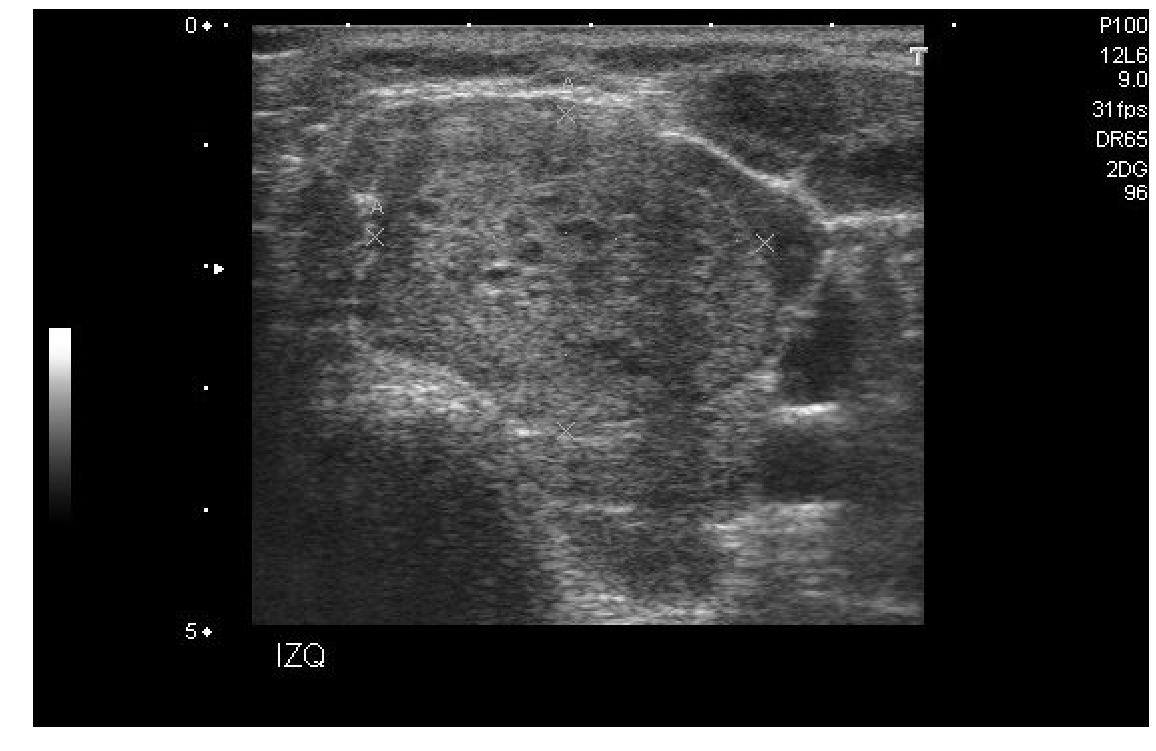

In [0]:
%matplotlib inline
# pic/temp.png is a 24-bit RGB image file
# 24-bit means that 8 bits are allocated to R, G, and B. In other words, each color can have 256 different values
img = mpimg.imread('./'+images.filename[200])  # use 'images' with full directory. Used 'bbox2' from below because Google Drive folder is customized
plt.figure(figsize=(20, 20))
imgplot = plt.imshow(img)
imgplot.axes.axis('off')
plt.show()

In [0]:
print('Image shape (Rows, Columns): ', img.shape)

Image shape (Rows, Columns):  (360, 560, 3)


- - - 

<p><a name="dataframes"></a></p>
**5. CREATING DATA SETS:**
<br><a href="#home">BACK TO THE TOP</a>

Creating a dataframe of bounding box coordinates and image file paths:

In [0]:
coors2  = coors.drop('id', axis=1)
images2 = images.drop(['case_id', 'mark'], axis=1)

In [0]:
bbox = pd.merge(coors2, images2, left_on = 'image_id', right_on = 'id', how = 'inner')
bbox = bbox.drop('id', axis=1)

In [0]:
# Picking images only in the thyroid folder due to duplicates in benign and malignant folders
mask = [True if 'thyroid' in bbox.filename[i] else False for i in range(len(bbox.filename))]
bbox = bbox.loc[mask].reset_index(drop=True)

Modifying 'filename', 'w' and 'h' columns, in order to format them for modeling

In [0]:
# Adding './' so that keras can use column as file path
bbox['filename'] = ['./'+bbox.filename[i] for i in range(len(bbox.filename))]

# Converting width and height distances to bottom-right coordinate (of bounding boxes)
bbox['x2']       = [bbox.x[i]+bbox.w[i]   for i in range(len(bbox.w))]
bbox['y2']       = [bbox.y[i]+bbox.h[i]   for i in range(len(bbox.h))]
bbox.drop(['w','h'], axis=1)

# Renaming 'x' and 'y' to 'x1' and 'y1'
bbox = bbox.rename(columns={'x': 'x1', 'y': 'y1'})

# Reording columns for easier concatenation with augmented images later 
bbox = bbox[['image_id','x1','y1','x2','y2','filename']]

In [0]:
# SANITY CHECK
print('Rows and Columns: ', bbox.shape, '\nNumber of rows can translate to aggregate number of bounding boxes',\
      '\n\nNew dataframe sample:')
bbox.sample(5)

Rows and Columns:  (639, 6) 
Number of rows can translate to aggregate number of bounding boxes 

New dataframe sample:


,image_id,x1,y1,x2,y2,filename
453,461,130,85,261,196,./cimalab/thyroid/348_1.jpg
132,225,123,112,239,164,./cimalab/thyroid/163_1.jpg
245,306,349,38,473,129,./cimalab/thyroid/225_2.jpg
558,561,367,91,484,173,./cimalab/thyroid/63_1.jpg
345,366,413,117,458,170,./cimalab/thyroid/274_1.jpg


- - -

Checking for "double" images and creating data frame of only unique images

In [0]:
mask = bbox.duplicated(subset='filename', keep='first')
dup_bbox = bbox.loc[mask]

In [0]:
index = iter(dup_bbox.index)

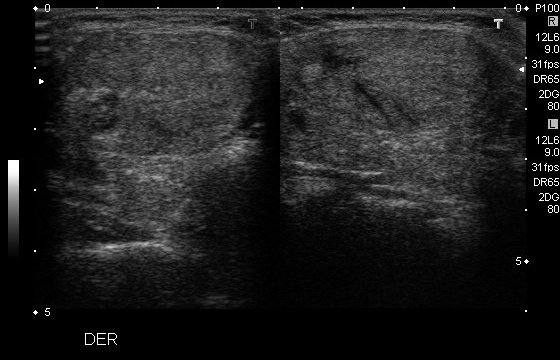

In [0]:
# Next function on iter object allows us to check each image by repeatedly running this cell
image = Image.open(dup_bbox.filename[next(index)])
image

Percentage of images from "thyroid" folder that are double images:

In [0]:
print(round((len(dup_bbox.filename.unique())/len(bbox.filename.unique()))*100,3), '%')

36.91 %


- - -

Creating final data frame with "double" images removed:

In [0]:
mask2 = bbox.duplicated(subset='filename', keep=False)
bbox2 = bbox.loc[-mask2]

In [0]:
bbox2.reset_index(drop=True, inplace=True)

In [0]:
len(bbox2)

294

 - - -

<p><a name="augment"></a></p>
**6. IMAGE AUGMENTATION**
<br><a href="#home">BACK TO THE TOP</a>

In [0]:
# import imgaug as ia
# from   imgaug import augmenters as iaa

In [0]:
ia.seed(1)

# Setting up augmented transformation parameters:
seq   = iaa.Sequential([
    iaa.Fliplr                (0.5),                 # Mirror (Horizontal)
    iaa.ContrastNormalization ((0.75, 1.5)),         # Contrast
    iaa.Multiply              ((0.8, 1.2)),          # Brightness
    iaa.Affine                (rotate = (-15, 15))], # Rotation
    random_order=True) 

seq_det = seq.to_deterministic()

# Empty lists to be appended with augmented image info
aug_image_id_list = []
aug_x1_list       = []
aug_y1_list       = []
aug_x2_list       = []
aug_y2_list       = []
aug_filename_list = []

Applying augmentations and generating new images<br>(RUNNING THIS CELL OUTPUTS THE AUGMENTED IMAGES):

In [0]:
times = 10 # Determines the number of augmented images generated, integer value must be set by the user 
           # (294 x 10 = 2,940)

for i in range(len(bbox2.filename)):
    # Pulling in each image and bounding box coordinates
    image     = np.array(PIL.Image.open(bbox2.filename[i]), dtype = np.uint8)
    bbs_list  = []  # Per imgaug library, ia.augment_bounding_boxes must be an iterable
    bb        = ia.BoundingBox(x1    = bbox2.x1[i], 
                               y1    = bbox2.y1[i],
                               x2    = bbox2.x2[i],
                               y2    = bbox2.y2[i])
    bbs_list.append(bb)
    bbs = ia.BoundingBoxesOnImage(bbs_list, shape=image.shape)
    
    # Applying augmentations outlined in imgaug.Sequential object/class
    image_aug = seq_det.augment_images        ([image]*times)
    bbs_aug   = seq_det.augment_bounding_boxes([bbs]  *times)
                                        
    for j in range(len(image_aug)):
                                        
        # Creating filename (aug_image_id) and filepath (aug_filename)
        aug_image_id = 'aug_'+bbox2.filename[i][18:-4]+'_'+str(j)
        aug_filename = './cimalab/thyroid/aug/'+aug_image_id+'.jpg'
                                        
        # Saving augmented images as jpgs
        img = PIL.Image.fromarray(image_aug[j])
        img.save(aug_filename)
                                        
        # Appending image_id and filename lists
        aug_image_id_list.append(aug_image_id)
        aug_filename_list.append(aug_filename)
                                        
        # Appending bounding box coords lists
        aug_x1_list.append(bbs_aug[j].bounding_boxes[0].x1)
        aug_y1_list.append(bbs_aug[j].bounding_boxes[0].y1)
        aug_x2_list.append(bbs_aug[j].bounding_boxes[0].x2)
        aug_y2_list.append(bbs_aug[j].bounding_boxes[0].y2)

Check on output:

/usr/local/lib/python3.6/dist-packages/imgaug/augmentables/bbs.py:548: DeprecationWarning: Usage of argument 'thickness' in BoundingBox.draw_on_image() is deprecated. The argument was renamed to 'size'.
  "Usage of argument 'thickness' in BoundingBox.draw_on_image() "


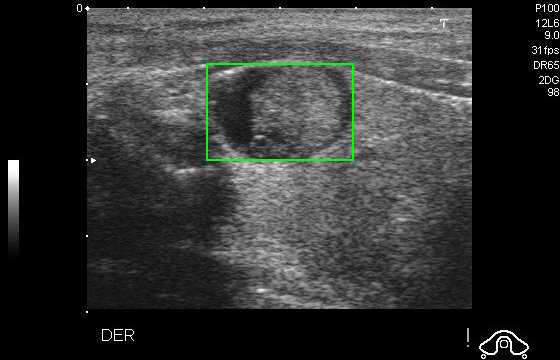

In [0]:
box = bbs.draw_on_image(image, thickness=2)
PIL.Image.fromarray(box)

/usr/local/lib/python3.6/dist-packages/imgaug/augmentables/bbs.py:548: DeprecationWarning: Usage of argument 'thickness' in BoundingBox.draw_on_image() is deprecated. The argument was renamed to 'size'.
  "Usage of argument 'thickness' in BoundingBox.draw_on_image() "


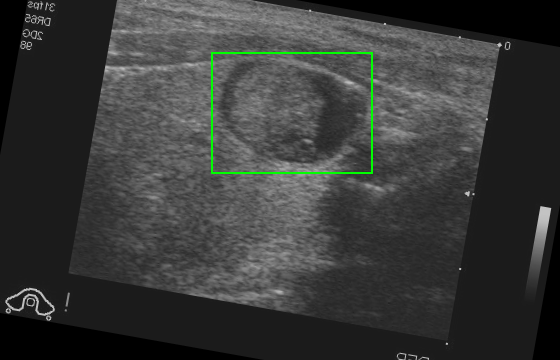

In [0]:
box2 = bbs_aug[0].draw_on_image(image_aug[0], thickness=2)
PIL.Image.fromarray(box2)

Concatenating augmented image rows to train csv

In [0]:
aug_df = pd.DataFrame({'image_id':aug_image_id_list,
                       'x1'       :aug_x1_list,
                       'y1'       :aug_y1_list,
                       'x2'       :aug_x2_list,
                       'y2'       :aug_y2_list,
                       'filename':aug_filename_list})
# Sanity Check:
print(aug_df.shape)

(2940, 6)


In [0]:
bbox2 = pd.concat([bbox2, aug_df])

In [0]:
bbox2.reset_index(drop = True, inplace = True)

In [0]:
bbox2.sample(10)

,image_id,x1,y1,x2,y2,filename
992,aug_220_1_8,167.654573,31.462428,368.050582,262.804657,./cimalab/thyroid/aug/aug_220_1_8.jpg
1733,aug_323_1_9,118.554161,50.346032,412.018114,186.400688,./cimalab/thyroid/aug/aug_323_1_9.jpg
1694,aug_32_1_0,252.338823,107.237753,356.002016,191.483879,./cimalab/thyroid/aug/aug_32_1_0.jpg
1100,aug_252_1_6,174.024175,62.724647,316.560589,142.573188,./cimalab/thyroid/aug/aug_252_1_6.jpg
640,aug_158_2_6,245.603990,137.189362,333.523624,225.108995,./cimalab/thyroid/aug/aug_158_2_6.jpg
2326,aug_371_1_2,253.976316,82.853313,335.087495,175.607305,./cimalab/thyroid/aug/aug_371_1_2.jpg
468,aug_130_1_4,131.313825,25.197071,405.013453,219.409102,./cimalab/thyroid/aug/aug_130_1_4.jpg
1930,aug_340_1_6,243.975323,120.423962,297.111662,184.169018,./cimalab/thyroid/aug/aug_340_1_6.jpg
1914,aug_34_1_0,209.021295,78.843907,327.198211,185.694201,./cimalab/thyroid/aug/aug_34_1_0.jpg
324,aug_108_1_0,216.887217,71.494327,338.446662,159.882949,./cimalab/thyroid/aug/aug_108_1_0.jpg


- - -

<p><a name="tvt"></a></p>
** 7. CREATING TRAINING, VALIDATION AND TEST SPLITS**
<br><a href="#home">BACK TO THE TOP</a>

Splitting dataframe into training, validation and test sets:

In [0]:
train, validation, test = np.split(bbox2, [int(.6*len(bbox2)), int(.8*len(bbox2))])

In [0]:
print('Output Check: ',\
      '\nTrain:      ', train.shape,\
      '\nValidation: ', validation.shape,\
      '\nTest:       ', test.shape)

Output Check:  
Train:       (1940, 6) 
Validation:  (647, 6) 
Test:        (647, 6)


 - - -

<p><a name="print"></a></p>
**8. PRINTING FINAL DATAFRAME TO CSV:**
<br><a href="#home">BACK TO THE TOP</a>

In [0]:
bbox.to_csv('./cimalab/dataframe/bbox.csv')

In [0]:
bbox2.to_csv('./cimalab/dataframe/bbox2.csv')

In [0]:
train.to_csv('./cimalab/dataframe/train.csv')

In [0]:
validation.to_csv('./cimalab/dataframe/validation.csv')

In [0]:
test.to_csv('./cimalab/dataframe/test.csv')

- - -